<a href="https://colab.research.google.com/github/bubbobne/satelliteWithPython/blob/master/load_sat_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite and rasterio








## Get and load data

To download satellite [*Copernicous*](https://www.copernicus.eu/en) in this notebook I use the [*sentinelsat*](https://sentinelsat.readthedocs.io/en/stable/api.html) package, which provide a python API to retrive data.

### Search Query

The [search query](https://scihub.copernicus.eu/userguide/FullTextSearch)available are:

* **platformname** (e.g. 'Sentinel-2')
* **filename**
* **beginposition/enposition/ingesiondate**  (keyword **data** in python ???)
* **footprint** region of interest
* **orbitnumber/lastorbitnumber/relativeorbitnumber/lastrelativeorbitnumber**  (trentino 43 relative?)
* **orbitdirection**
* **polarizatiomde** ??
* **producttype** (e.g. for [*Sentinel-2*](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/product-types))
* **sensoroperationalmode** ???
* **cloudcoveragepercentage**

Each costellations adopt a file naming convention, for *Sentinel-2* some keywords are:

* **Bxx**: band index
* **Wx**: completeness (x=F full orbit, x=P partial orbit)
* **Ly**: degradation ID (y=N nominal, y=D degraded)
* **MSIxxx**: xxx==level
* **R000**: relative orbit number

### Create a footprint

To query data for a region of interest (*ROI*) it's necessary defined the ROI as a GeoJSON object. It's possible to read it from a file or define as Python object as in the code below:

In [ ]:
! pip install --upgrade geojson
! pip install --upgrade rasterio
! pip install --upgrade sentinelsat
! pip install --upgrade pyproj
import geojson

def create_geojson_bb (w,s,e,n):
  # note the double square brackets in Polygon
  # I'm not sure about crs definition
  my_feature = geojson.Feature(geometry=geojson.Polygon([[(w, s),(e, s),(e, n),(w, n),(w, s)]]))
  crs = {
    "type": "name",
    "properties": {
        "name": "EPSG:4326"
    }
  }
  return geojson.FeatureCollection([my_feature],crs=crs)


my_bounding_box = create_geojson_bb(11.079, 46.1179, 11.1759, 46.17)
my_bounding_box

Requirement already up-to-date: geojson in /usr/local/lib/python3.6/dist-packages (2.5.0)
Requirement already up-to-date: rasterio in /usr/local/lib/python3.6/dist-packages (1.1.5)
Requirement already up-to-date: sentinelsat in /usr/local/lib/python3.6/dist-packages (0.14)
Requirement already up-to-date: pyproj in /usr/local/lib/python3.6/dist-packages (2.6.1.post1)


{"crs": {"properties": {"name": "EPSG:4326"}, "type": "name"}, "features": [{"geometry": {"coordinates": [[[11.079, 46.1179], [11.1759, 46.1179], [11.1759, 46.17], [11.079, 46.17], [11.079, 46.1179]]], "type": "Polygon"}, "properties": {}, "type": "Feature"}], "type": "FeatureCollection"}

### Prepare for download

 Initialize the class with credentials and url

In [ ]:


from sentinelsat.sentinel import SentinelAPI, geojson_to_wkt

sentinelAPI = SentinelAPI(
    user="******",
    password="******",
    api_url='https://scihub.copernicus.eu/dhus'
)

performe some query and print the json response

In [ ]:
import json
import datetime

products = sentinelAPI.query(
    geojson_to_wkt(my_bounding_box),
    date=('20151219', datetime.date(2015, 12, 29)),
    platformname = "Sentinel-2",
    cloudcoverpercentage=(0,40)
)

def json_date_converter(o):
    if isinstance(o, datetime.datetime):
        return o.__str__()
    
print(json.dumps(products, default = json_date_converter, indent = 2))




{
  "be108d50-a166-476e-a1b7-5093990fef32": {
    "title": "S2A_MSIL1C_20151224T102432_N0201_R065_T32TPS_20151224T102435",
    "link": "https://scihub.copernicus.eu/dhus/odata/v1/Products('be108d50-a166-476e-a1b7-5093990fef32')/$value",
    "link_alternative": "https://scihub.copernicus.eu/dhus/odata/v1/Products('be108d50-a166-476e-a1b7-5093990fef32')/",
    "link_icon": "https://scihub.copernicus.eu/dhus/odata/v1/Products('be108d50-a166-476e-a1b7-5093990fef32')/Products('Quicklook')/$value",
    "summary": "Date: 2015-12-24T10:24:32.035Z, Instrument: MSI, Mode: , Satellite: Sentinel-2, Size: 752.16 MB",
    "datatakesensingstart": "2015-12-24 10:24:32.035000",
    "beginposition": "2015-12-24 10:24:32.035000",
    "endposition": "2015-12-24 10:24:32.035000",
    "ingestiondate": "2019-01-10 00:38:12.354000",
    "orbitnumber": 2636,
    "relativeorbitnumber": 65,
    "cloudcoverpercentage": 19.0,
    "gmlfootprint": "<gml:Polygon srsName=\"http://www.opengis.net/gml/srs/epsg.xml#4326\

get info of the product by id


In [ ]:
product_info = sentinelAPI.get_product_odata("be108d50-a166-476e-a1b7-5093990fef32")


product_info

{'Creation Date': datetime.datetime(2019, 1, 11, 21, 57, 1, 602000),
 'Ingestion Date': datetime.datetime(2019, 1, 10, 0, 38, 12, 354000),
 'Online': True,
 'date': datetime.datetime(2015, 12, 24, 10, 24, 32, 35000),
 'footprint': 'POLYGON((10.31403528 46.94616825,10.29048407 45.95826452,11.70625433 45.9334965,11.75558492 46.92053639,10.31403528 46.94616825,10.31403528 46.94616825))',
 'id': 'be108d50-a166-476e-a1b7-5093990fef32',
 'md5': '98a2700e6ccb5e4a72b95fa3113e92ce',
 'size': 788734509,
 'title': 'S2A_MSIL1C_20151224T102432_N0201_R065_T32TPS_20151224T102435',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('be108d50-a166-476e-a1b7-5093990fef32')/$value"}

another query

In [ ]:
#perform a query on the last month
products_2 = sentinelAPI.query(
    geojson_to_wkt(my_bounding_box),
    date=('NOW-1MONTHS', 'NOW'),
    platformname = "Sentinel-2",
    cloudcoverpercentage=(0,50)
)

print(json.dumps(products_2, default = json_date_converter, indent = 2))

{
  "83cbde7d-563d-4ec9-8880-d422e97f895f": {
    "title": "S2A_MSIL1C_20200806T101031_N0209_R022_T32TPS_20200806T111503",
    "link": "https://scihub.copernicus.eu/dhus/odata/v1/Products('83cbde7d-563d-4ec9-8880-d422e97f895f')/$value",
    "link_alternative": "https://scihub.copernicus.eu/dhus/odata/v1/Products('83cbde7d-563d-4ec9-8880-d422e97f895f')/",
    "link_icon": "https://scihub.copernicus.eu/dhus/odata/v1/Products('83cbde7d-563d-4ec9-8880-d422e97f895f')/Products('Quicklook')/$value",
    "summary": "Date: 2020-08-06T10:10:31.024Z, Instrument: MSI, Mode: , Satellite: Sentinel-2, Size: 816.10 MB",
    "datatakesensingstart": "2020-08-06 10:10:31.024000",
    "beginposition": "2020-08-06 10:10:31.024000",
    "endposition": "2020-08-06 10:10:31.024000",
    "ingestiondate": "2020-08-06 17:51:13.182000",
    "orbitnumber": 26760,
    "relativeorbitnumber": 22,
    "cloudcoverpercentage": 5.7338,
    "sensoroperationalmode": "INS-NOBS",
    "gmlfootprint": "<gml:Polygon srsName=\"h

Iterate throghout  products

In [ ]:
products_df = sentinelAPI.to_dataframe(products_2)
products_df_sorted = products_df.sort_values(['cloudcoverpercentage', 'ingestiondate'], ascending=[True, True])
products_id = []
# plot product
for index, row in products_df_sorted.iterrows():
    products_id.append(index)
    print(sentinelAPI.get_product_odata(index))
    print(index," orbit number: {}".format(row['relativeorbitnumber']), "cloud percentage: {}".format(row['cloudcoverpercentage']))

{'id': '1cf3f43e-fe18-4998-8585-a219d1dcf731', 'title': 'S2B_MSIL1C_20200801T100559_N0209_R022_T32TPS_20200801T130136', 'size': 859471232, 'md5': 'BD12241F25AAC9FFDF476019D6ACADC5', 'date': datetime.datetime(2020, 8, 1, 10, 5, 59, 24000), 'footprint': 'POLYGON((10.31401641418595 46.945376873119585,10.314302273018109 46.94616350663998,11.755584916064224 46.920536388192055,11.706254333045143 45.93349650488509,10.290484068727272 45.95826451839171,10.31401641418595 46.945376873119585))', 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('1cf3f43e-fe18-4998-8585-a219d1dcf731')/$value", 'Online': True, 'Creation Date': datetime.datetime(2020, 8, 1, 20, 49, 9, 128000), 'Ingestion Date': datetime.datetime(2020, 8, 1, 20, 48, 58, 334000)}
1cf3f43e-fe18-4998-8585-a219d1dcf731  orbit number: 22 cloud percentage: 1.7485000000000002
{'id': 'd38f43ae-8cf6-4b6e-bd22-3182de2631c6', 'title': 'S2B_MSIL2A_20200801T100559_N0214_R022_T32TPS_20200801T135302', 'size': 1224164291, 'md5': '2C2DC936F7

In [ ]:
product_info = sentinelAPI.get_product_odata(products_id[1])
print(products_id[1])

d38f43ae-8cf6-4b6e-bd22-3182de2631c6


Download products

In [ ]:
products_df = sentinelAPI.to_dataframe(products)
products_df_sorted = products_df.sort_values(['cloudcoverpercentage', 'ingestiondate'], ascending=[True, True])
products_df_sorted = products_df_sorted.head(5)
#sentinelAPI.download_all(products_df_sorted.index)


In [ ]:
products_df = sentinelAPI.to_dataframe(products)
products_df_sorted = products_df.sort_values(['cloudcoverpercentage', 'ingestiondate'], ascending=[True, True])
products_df_sorted = products_df_sorted.head(5)


 extract the zip

In [ ]:
dst_folder_name = "./data"
#a= products_df_sorted.iloc[[0]]['title']
#from zipfile import ZipFile
#ZipFile("./"+a[0]+".zip").extractall(dst_folder_name)

### Search for colour image

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/Colab Notebooks/data"


data
load_sat_data.ipynb
Monitoring_surface_water_mileston_1.ipynb
Monitoring_surface_water_mileston_1_v2.ipynb
Untitled
Untitled0.ipynb


In [ ]:
import os
raster_path='/content/gdrive/My Drive/Colab Notebooks/data'
for root, dirs, files in os.walk(raster_path):
    for file in files:
      if "TCI" in file:
        raster_path = os.path.join(root,file)
        print(raster_path)
        #append the file name to the list
		#print(os.path.join(root,file))


/content/gdrive/My Drive/Colab Notebooks/data/S2A_MSIL1C_20151224T102432_N0201_R065_T32TPS_20151224T102435.SAFE/GRANULE/L1C_T32TPS_A002636_20151224T102435/IMG_DATA/T32TPS_20151224T102432_TCI.jp2


## Working with rasterio

Read the file downloaded (true color image) and cut on the window.


Requirement already up-to-date: planar in /usr/local/lib/python3.6/dist-packages (0.4)
Requirement already up-to-date: pyproj in /usr/local/lib/python3.6/dist-packages (2.6.1.post1)
crs: EPSG:32632
width: 10980 height: 10980
558
-788


/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:294: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(" ".join((projstring, projkwargs)))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axi

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['show']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
/usr/local/lib/python3.6/dist-packages/PIL/Image.py:2766: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


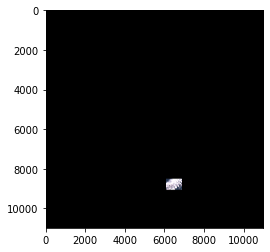

In [ ]:
!pip install --upgrade planar
!pip install --upgrade pyproj

import rasterio
from rasterio.crs import CRS
from rasterio.windows import Window
from pyproj import Proj, transform
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
dst_folder_name = '/content/gdrive/My Drive/Colab Notebooks/data'
dst_crs = 'EPSG:4326'
with rasterio.open(raster_path, driver='JP2OpenJPEG') as raster_data:
    print("crs: "+raster_data.crs.to_string())
    print("width: {} height: {}".format(raster_data.width,raster_data.height))
    lon1, lat1 = 11.079,46.17
    lon2, lat2 = 11.179,46.1179
    if raster_data.crs!= CRS.from_epsg(4326):
        outProj = Proj(init=raster_data.crs.to_string())
        inProj = Proj(init='epsg:4326')
        x1,y1 = transform(inProj, outProj, lon1, lat1)
        x2,y2 = transform(inProj, outProj, lon2, lat2)
        row_start, col_stop = raster_data.index(x1, y1)
        row_stop, col_start =  raster_data.index(x2, y2)
    else:
        row_start, col_stop = raster_data.index(lon1, lat1)
        row_stop, col_start =  raster_data.index(lon2, lat2)
    
    print(row_stop-row_start)
    print(col_stop-col_start)
    profile = raster_data.profile.copy()
    profile.update(compress='lzw')
    w = Window.from_slices(slice(row_start, row_stop), slice( col_stop,col_start))
    with rasterio.open(dst_folder_name + "/cropped_raster.tif", 'w', **profile) as dst:
        dst.write(raster_data.read(window=w), window=w)

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(dst_folder_name + "/cropped_raster.tif")
imgplot = plt.imshow(img)
plt.show()
  

In [ ]:
with rasterio.open(dst_folder_name + "/cropped_raster.tif") as raster_data:
    print("crs: "+raster_data.crs.to_string())
    print("width: {} height: {}".format(raster_data.width,raster_data.height))

crs: EPSG:32632
width: 10980 height: 10980


reproject

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

dst_crs = 'EPSG:4326'

with rasterio.open(raster_path, driver='JP2OpenJPEG') as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })
    with rasterio.open(dst_folder_name+'/reprojected_TCI.tif', 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

In [ ]:
import pprint
from rasterio import features

with rasterio.open(dst_folder_name+'/cropped_raster.tif') as src:
    blue = src.read(3)

mask = blue != 255
shapes = features.shapes(blue, mask=mask)
pprint.pprint(next(shapes))

({'coordinates': [[(6326.0, 8493.0),
                   (6326.0, 8495.0),
                   (6327.0, 8495.0),
                   (6327.0, 8493.0),
                   (6326.0, 8493.0)]],
  'type': 'Polygon'},
 1.0)


## Tensorflow and keras

In [ ]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.3.0)


In [ ]:
import tensorflow as tf
print("Is version greater than 2.0: {}".format(tf.__version__ >= '2.0.0'))

Is version greater than 2.0: True


<class 'numpy.ndarray'>
(788, 558, 3)
255
255
255


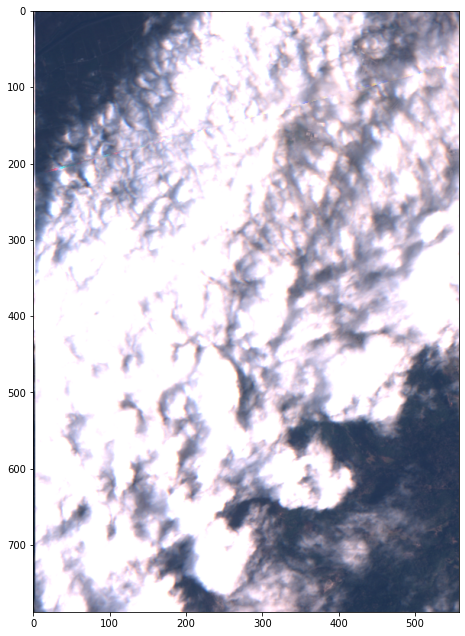

In [ ]:
with rasterio.open(raster_path, driver='JP2OpenJPEG') as r:
  a =np.transpose(np.roll(r.read(window = w),(1,2,0),1))
  #a = np.roll(a,1)

  print(type(a))
  print(a.shape)
  for i in range(0,3):
    print(a[i].max())
  #change format
  b=np.random.randint(255, size=a[1].shape)
  fig = plt.figure(figsize=(16, 16*height/width))
  plt.imshow(a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


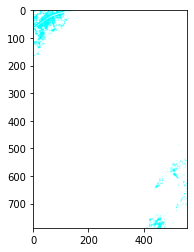

In [ ]:
plt.imshow(tf.compat.v1.keras.preprocessing.image.apply_brightness_shift(a,0.1))


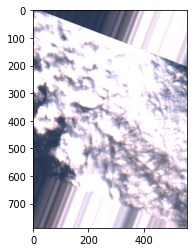

In [ ]:
plt.imshow(tf.keras.preprocessing.image.random_rotation(
    a, 180, row_axis=1, col_axis=0, channel_axis=2, fill_mode='nearest', cval=0.0,
    interpolation_order=1
))